# Final tables
    
## Instruction Notebook

The notebook allows the user to construct to different level of aggregation:

- `industry`
- `geocode4_corr` -> city

By default, the `aggregation_param` parameter is set to `industry`. To switch to city, change for `geocode4_corr`. Then launch the notebook for new results

In the paper, we define a threshold to distinguish cities or industries. Choose among this set of threshold:

- 5
- 6
- 7
- 8
- mean

By default, the `threshold_full` parameter is set to `6`. To switch to another threshold, change the threshold `threshold_full`. Then launch the notebook for new results


In [1]:
import pandas as pd
from Fast_connectCloud import connector
import numpy as np

In [2]:
import sys, os
sys.path.insert(0,'..')

In [3]:
import functions.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [4]:
options(warn=-1)
shhh <- suppressPackageStartupMessages
shhh(library(tidyverse))
shhh(library(lfe))
shhh(library(lazyeval))
shhh(library('progress'))

path = "../functions/SBC_pollution_R.R"
source(path)
path = "../functions/SBC_pollutiuon_golatex.R"
source(path)

In [5]:
change_target <- function(table){
    check_target <- grep("PeriodAfter:polluted_threAbove:target_c$", rownames(table$coef))
    
    if (length(check_target) !=0) {
    rownames(table$coefficients)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
    rownames(table$beta)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
}
    return (table)
}

In [6]:
gs = connector.open_connection(online_connection = False,
                              path_credential = '/Users/thomas/Google Drive/Projects/Client_Oauth/Google_auth')

service = gs.connect_remote('GCP')

Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0xa1936bed0> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0xa17aefa90> and accessible with "bigquery_account"


# Load Data

## Paper dataset

In [7]:
%put df_final --to R

from GoogleDrivePy.google_platform import connect_cloud_platform
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project, 
                                             service_account = service['GoogleCloudP'])    
query = (
          "SELECT * "
            "FROM China.SBC_pollution_China "

        )

df_final = gcp.upload_data_from_bigquery(query = query, location = 'US')
#df_final.head()

/Users/thomas/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [8]:
df_final <- df_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )
#head(df_final)

In [9]:
#aggregation_param = 'industry'
aggregation_param = 'geocode4_corr'
list_agg = df_final[aggregation_param].to_list()

threshold_full = 6

In [10]:
%put aggregation_param --to R
%put threshold_full --to R

## Compute Herfhindal: proxy Size

$$
H=\sum_{i=1}^{N} s_{i}^{2}
$$

where $s_i$ is the market share of industry[city] $i$ in a city [industry], and $N$ is the number of firms. 

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city-industry: `market_share_cit`
- Step 2: compute the sum of squared market share by industry[city]: `Herfindahl_agg_t`
- Step 3: Compute the average across time: `Herfindahl_agg`
- Step 4: Compute the deciles of step 3: `decile_herfhindal_agg`
    - Low decile implies a low concentration within sectors
    - High decile implies a high concentration within sectors

In [11]:
query = """
WITH sum_cit AS (
  SELECT geocode4_corr, cic as industry, sum(output) as sum_o_cit, year
  FROM China.asif_firm_china 
  WHERE year >= 2002 AND year <= 2007
  AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY geocode4_corr, cic, year
) 
SELECT * 
FROM 
  (WITH sum_agg_t AS (
    SELECT {0}, SUM(sum_o_cit) as sum_o_agg_t, year
    FROM sum_cit
    WHERE year >= 2002 AND year <= 2007
    GROUP BY year, {0}
)
SELECT *
FROM
  (WITH ms_cit AS (
    SELECT  sum_cit.industry, sum_cit.geocode4_corr, sum_cit.year,
    sum_cit.sum_o_cit/NULLIF(sum_agg_t.sum_o_agg_t, 0) as market_share_cit
    FROM sum_cit
    LEFT JOIN sum_agg_t
ON (
sum_cit.year = sum_agg_t.year AND 
sum_cit.{0} = sum_agg_t.{0}
)
)
SELECT *
FROM
  (WITH agg_1 AS (
SELECT {0}, SUM(POW(market_share_cit, 2)) as Herfindahl_agg_t,
year
FROM ms_cit
GROUP BY year, {0}
ORDER BY year, {0} 
)
SELECT *
FROM (
SELECT {0},
AVG(Herfindahl_agg_t) as Herfindahl_agg
FROM agg_1
GROUP BY {0}
ORDER BY {0}
)

)))
"""
df_herfhindal = (gcp.upload_data_from_bigquery(
    query = query.format(aggregation_param),
                                         location = 'US')
                 .loc[lambda x: x[aggregation_param].isin(list_agg)]
                )

#df_herfhindal.shape

## Compute Ownership: proxy Foreign/SOE

$$\sum output_{agg,o}/ \sum output_{agg}$$

- with $agg$ stands for industry[city]
- $o$ stands for ownership (Foreign vs Domestic or SOE vs private)



### Foreign vs domestic

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry[city], ownership (Foreign/Domestic): `Share_X_agg_o`
- ~Step 2: Compute dummy when share Foreign above share domestic by industry[city]~
- Step 3: Compute decile by industry[city]-ownership
    - Note,  high decile in Foreign means the industry[city] has relatively high share of foreign output, but not in absolule value as in step 2. A decile 9 in foreign can be a decile 2 or 3 in Domestic

In [12]:
OWNERSHIP = 'Foreign'
query_share_ = """ 
WITH sum_agg_o AS (
  SELECT 
    case WHEN ownership = '{2}' THEN '{2}' ELSE '{3}' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_agg_o, 
    SUM(fa_net / 10000000) as fa_net_agg_o, 
    SUM(employment / 100000) as employment_agg_o,
    {1} as {0}
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007 
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    {0}
) 
SELECT 
  * 
FROM 
  (
    WITH sum_agg AS(
      SELECT 
        SUM(output_agg_o) as output_agg, 
        SUM(fa_net_agg_o) as fa_net_agg, 
        SUM(employment_agg_o) as employment_agg, 
        {0} AS {0}_b
      FROM 
        sum_agg_o 
      GROUP BY 
        {0}
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_agg_o AS(
          SELECT 
            OWNERSHIP, 
            output_agg_o / output_agg AS share_output_agg_o, 
            fa_net_agg_o / fa_net_agg AS share_fa_net_agg_o, 
            employment_agg_o / employment_agg AS share_employement_agg_o, 
            {0}
          FROM 
            sum_agg_o 
            LEFT JOIN sum_agg ON sum_agg_o.{0} = sum_agg.{0}_b 
        ) 
        SELECT 
        {0},
        OWNERSHIP,  
        share_output_agg_o,
        share_fa_net_agg_o,
        share_employement_agg_o
        FROM share_agg_o
        WHERE OWNERSHIP = '{2}'
        )
        )
"""
if aggregation_param == 'industry':
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    query_share_foreign= query_share_.format(aggregation_param,
                                             'cic',
                                             OWNERSHIP,
                                            counterpart)
else:
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    query_share_foreign = query_share_.format(aggregation_param,
                                              aggregation_param,
                                              OWNERSHIP,
                                             counterpart)
df_share_foreign = (gcp.upload_data_from_bigquery(query = query_share_foreign,
                                         location = 'US')
                    .loc[lambda x: x[aggregation_param].isin(list_agg)]
                   )
#df_share_foreign.shape 

### SOE vs Private

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry[city], ownership (SOE/PRIVATE): `Share_X_agg_o`
- ~Step 2: Compute dummy when share SOE above share domestic by industry[city]~
- Step 3: Compute decile by industry[city]-ownership
    - Note,  high decile in SOE means the industry[city] has relatively high share of SOE output, but not in absolule value as in step 2. A decile 9 in SOE can be a decile 2 or 3 in Domestic

In [13]:
OWNERSHIP = 'SOE'
if aggregation_param == 'industry':
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    df_share_soe= query_share_.format(aggregation_param,
                                             'cic',
                                             OWNERSHIP,
                                            counterpart)
else:
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    df_share_soe = query_share_.format(aggregation_param,
                                              aggregation_param,
                                              OWNERSHIP,
                                             counterpart)
    
df_share_soe = (gcp.upload_data_from_bigquery(query = df_share_soe,
                                         location = 'US')
                    .loc[lambda x: x[aggregation_param].isin(list_agg)]
                   )
#df_share_soe.shape 

#df_share_soe['rank_share_output_i'].value_counts().sort_index()

## Load TCZ_list_china from Google Spreadsheet

Feel free to add description about the dataset or any usefull information.

Profiling will be available soon for this dataset

In [14]:
#df_TCZ_list_china = read_csv('../df_TCZ_list_china.csv',
#                            col_types = cols(
#  Province = col_character(),
#  City = col_character(),
#  geocode4_corr = col_double(),
#  TCZ = col_double(),
#  SPZ = col_double()
#)) %>% 
#select(-c(TCZ, Province)) %>% 
#right_join(df_final, by = 'geocode4_corr') 

## Load chinese_city_characteristics from Google Spreadsheet

Feel free to add description about the dataset or any usefull information.

Profiling will be available soon for this dataset

In [15]:
df_kuznet <- read_csv('../df_chinese_city_characteristics.csv',
        col_types = cols(
  geocode4_corr = col_double(),
  year_lagged = col_double(),
  gdp = col_double(),
  population = col_double(),
  year = col_double(),
  gdp_cap = col_double(),
  ln_gdp_cap = col_double(),
  ln_gdp_cap_sqred = col_double(),
  ln_pop = col_double()
))  %>% 
left_join(df_final, by = c('year','geocode4_corr'))


## Create R tables

In [16]:
%put df_herfhindal_final --to R
df_herfhindal_final = (df_final.merge(df_herfhindal,
                                     on=[aggregation_param],
                                     how='left',
                                     indicator=True
                                     )
                       .assign(
                       decile_herfhindal = lambda x:
                           pd.qcut(x['Herfindahl_agg'],10, labels=False),
                       mean_herfhindal= 
                           lambda x: np.where(
                               x["Herfindahl_agg"] > 
                               x["Herfindahl_agg"].drop_duplicates().mean(),
                               1,0
                           ),
                       third_herfhindal= 
                           lambda x: np.where(
                               x["Herfindahl_agg"] >
                               (x["Herfindahl_agg"]
                                .drop_duplicates()
                                .quantile([.75])
                                .values[0]),
                               1,0
                           )
                       )
                       .merge(
                           pd.read_csv('../df_chinese_city_characteristics.csv'),
                       on = ['year', 'geocode4_corr'],
                       how = 'left'
                       )
                      )

INFO: NumExpr defaulting to 8 threads.

In [17]:
#print('Descriptive statistics:\n {}'.format(
#    df_herfhindal_final['Herfindahl_agg'].describe()))
#print('Mean: {}'.format(df_herfhindal_final["Herfindahl_agg"].mean()))
#print('Third decile: {}'.format(
#    (df_herfhindal_final["Herfindahl_agg"]
#     .drop_duplicates().quantile([.75]).values[0])))
#print(pd.qcut(df_herfhindal_final['Herfindahl_agg'],
#        10).drop_duplicates().sort_values().reset_index(drop = True))

#df_herfhindal_final['decile_herfhindal'].value_counts().sort_index()

In [18]:
df_herfhindal_r <- df_herfhindal_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [19]:
%put df_final_SOE --to R
#### If industry, we need to use out_share_SOE, cap_share_SOE,lab_share_SOE
##### Output share already computed in the paper's table for industry but not
##### for city, in the later case, we use the data from ASIF
if aggregation_param== 'industry':
    out = "out_share_SOE"
    cap = "cap_share_SOE"
    emp = "lab_share_SOE"
else:
    out = "share_output_agg_o"
    cap = "share_fa_net_agg_o"
    emp = "share_employement_agg_o"
    
df_final_SOE = (df_final.merge(
    df_share_soe,
    on = [aggregation_param],
    how = 'left',
    indicator = True
)
                .assign(
                       output = lambda x:
                           pd.qcut(x[out],10, labels=False),
                       capital = lambda x:
                           pd.qcut(x[cap],10, labels=False),
                       employment = lambda x:
                           pd.qcut(x[emp],10, labels=False),
                       mean_output = lambda x:np.where(
                    x[out] > x[out].drop_duplicates().mean(),
                           1,0
                       ),
                    mean_capital = lambda x:np.where(
                    x[cap] > x[cap].drop_duplicates().mean(),
                           1,0
                       ),
                    mean_employment = lambda x:np.where(
                    x[emp] > x[emp].drop_duplicates().mean(),
                           1,0
                       )
                    )
    .merge(
                           pd.read_csv('../df_chinese_city_characteristics.csv'),
                       on = ['year', 'geocode4_corr'],
                       how = 'left'
                       )

)
for i in ['output', 'capital', 'employment']:
    if i == 'output':
        v = out
    elif i =='capital':
        v = cap
    else:
        v = emp
    #print('Descriptive statistics \n: {}'.format(df_final_SOE[v].drop_duplicates().describe()))
    #print(pd.qcut(df_final_SOE[v],
    #    10).drop_duplicates().sort_values().reset_index(drop = True))

    #print(df_final_SOE[i].value_counts().sort_index())

In [20]:
df_final_SOE <- df_final_SOE %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [21]:
%put df_final_FOREIGN --to R
df_final_FOREIGN = (df_final.merge(
    df_share_foreign,
    on = [aggregation_param],
    how = 'left',
    indicator = True
)
                .assign(
                       output = lambda x:
                           pd.qcut(x['share_output_agg_o'],10, labels=False),
                       capital = lambda x:
                           pd.qcut(x['share_fa_net_agg_o'],10, labels=False),
                       employment = lambda x:
                           pd.qcut(x['share_employement_agg_o'],10, labels=False),
                    mean_output = lambda x:np.where(
                    x['share_output_agg_o'] > 
                        x['share_output_agg_o'].drop_duplicates().mean(),
                           1,0
                       ),
                    mean_capital = lambda x:np.where(
                    x['share_fa_net_agg_o'] > 
                        x['share_fa_net_agg_o'].drop_duplicates().mean(),
                           1,0
                       ),
                    mean_employment = lambda x:np.where(
                    x['share_employement_agg_o'] > 
                        x['share_employement_agg_o'].drop_duplicates().mean(),
                           1,0
                       )
                    )
)
for i in ['output', 'capital', 'employment']:
    if i == 'output':
        v = 'share_output_agg_o'
    elif i =='capital':
        v = 'share_fa_net_agg_o'
    else:
        v = 'share_employement_agg_o'
    #print('Median: {}'.format(df_final_FOREIGN[v].median()))
    #print(pd.qcut(df_final_FOREIGN[v],
    #    10).drop_duplicates().sort_values().reset_index(drop = True))

    #print(df_final_FOREIGN[i].value_counts().sort_index())

In [22]:
df_final_FOREIGN <- df_final_FOREIGN %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

# Table 3

1. Full sample

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{i}+\lambda_{t}+\phi_{k}+\epsilon_{i k t}
$$

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{ct}+\lambda_{kt}+\phi_{ck}+\epsilon_{i k t}
$$

2. SOE dominated
3. Foreign dominated


In [23]:
df_to_filter <- df_final_SOE
if (aggregation_param == 'geocode4_corr'){
    aggregation_param = 'city'
}
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

#'output', 'capital', 'employment'

t1 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter,
             exactDOF=TRUE)

t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter,
             exactDOF=TRUE)

### decile Output
t3 <- felm(formula=log(tso2_cit) ~ 
               target_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(output > 6),
             exactDOF=TRUE)

t4 <- felm(formula=log(tso2_cit) ~ 
               target_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(output > 7),
             exactDOF=TRUE)

t5 <- felm(formula=log(tso2_cit) ~ 
               target_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(output > 8),
             exactDOF=TRUE)

name = paste0("table_",1,".txt")
title = paste0("Table Baseline")
    
tables <- list(t1, t2, t3,t4, t5)
table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=title,
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name=name)

### decile Capital

### decile Employment

[1] TRUE

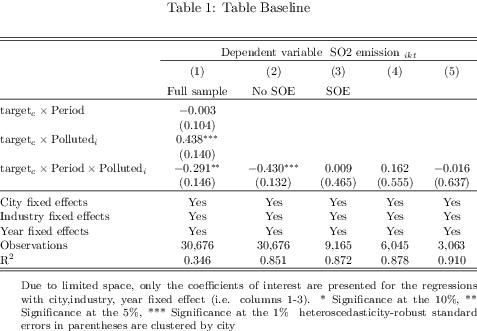

In [24]:
new_r = ['& Full sample', 'No SOE', 'SOE']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""

x = [a for a in os.listdir() if a.endswith(".txt")]
for i, val in enumerate(x):
    lb.beautify(table_number = i+1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = new_r,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 100)

# Table 4 parallel trend

$$
\begin{aligned}
\log \mathrm{SO} 2 \text { emission }_{i k t}=\sum_{t=2002}^{2007} \alpha\left(Target_{i} \times\right.& \text { Polluting sectors }\left._{k} \times y e a r_{t}\right) \\
&+\theta X_{i k t}+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
\end{aligned}
$$

1. Full sample
2. SOE dominated vs No SOE dominated
    - output
    - capital
    - employment

In [25]:
cat <- 'SOE'
#cut <- 'Mean'
#threshold <- 0
#var_ <- 'mean_herfhindal'
df_to_filter <- df_final_SOE
if (aggregation_param == 'geocode4_corr'){
    aggregation_param = 'city'
}
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

t1 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year) 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter,
             exactDOF=TRUE)
t1 <-change_target(t1)

### output
t2 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(output <= threshold_full),
             exactDOF=TRUE)
t2 <-change_target(t2)
    
t3 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(output > threshold_full),
             exactDOF=TRUE)
t3 <-change_target(t3)
    
### capital
t4 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(capital <= threshold_full),
             exactDOF=TRUE)
t4 <-change_target(t4)
    
t5 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(capital > threshold_full),
             exactDOF=TRUE)
t5 <-change_target(t5)
    
### employment
t6 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(employment <= threshold_full),
             exactDOF=TRUE)
t6 <-change_target(t6)
    
t7 <- felm(formula=log(tso2_cit) ~ 
               target_c * polluted_thre * as.factor(year)
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(employment > threshold_full),
             exactDOF=TRUE)
t7 <-change_target(t7)
    
name = paste0("table_",1,".txt")
    title = paste0("Parallel trend threshold used decile ", threshold_full)
    
tables <- list(t1, t2, t3, t4, t5, t6,t7)
table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=title,
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name=name)

[1] TRUE TRUE TRUE

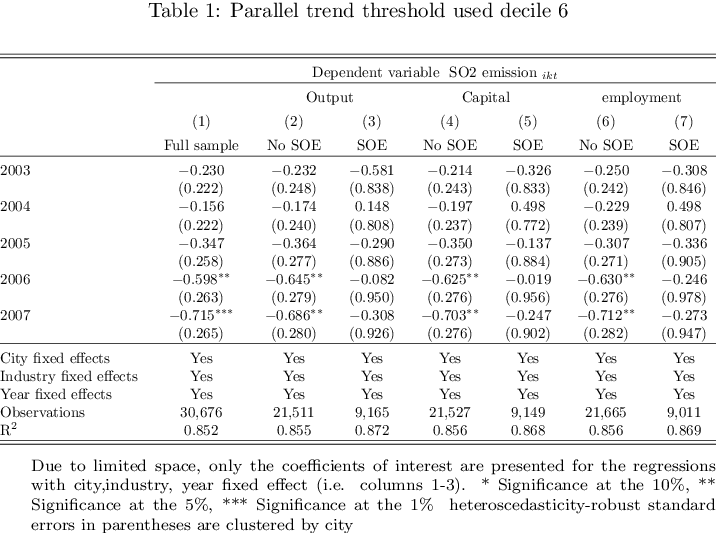

In [26]:
import os
new_r = ['& Full sample', 'No SOE', 'SOE', 'No SOE', 'SOE', 'No SOE', 'SOE']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""

multicolumn ={
    '':1,
    'Output': 2,
    'Capital': 2,
    'employment': 2
}
#os.remove('table_1.tex')
x = [a for a in os.listdir() if a.endswith(".txt")]
for i, val in enumerate(x):
    lb.beautify(table_number = i+1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = new_r,
            multicolumn = multicolumn,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 150)

# Diffusion chanels

- TCZ VS non TCZ
- Concentrated VS non concentrated
- Kuznet
    - TCZ
    - Concentration
    - SOE
- TFP

## TCZ VS non TCZ

In [27]:
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

df_to_filter <- df_final

fe1 <- list(c("City fixed effects", "Yes", "No", "Yes", "No"),
             c("Industry fixed effects", "Yes", "No", "Yes", "No"),
             c("Year fixed effects","Yes", "No", "Yes", "No"),
             c("City-year fixed effects", "No", "Yes","No", "Yes"),
             c("Industry-year fixed effects", "No", "Yes","No", "Yes"),
             c("City-industry fixed effects", "No", "Yes","No", "Yes")
             )


#### TCZ
t1 <- felm(formula=log(tso2_cit) ~ 
           target_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c == 'TCZ'),
             exactDOF=TRUE)
t1 <-change_target(t1)

t2 <- felm(formula=log(tso2_cit) ~ 
           target_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c == 'TCZ'),
             exactDOF=TRUE)
t2 <-change_target(t2)

#### No TCZ
t3 <- felm(formula=log(tso2_cit) ~ 
           target_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c != 'TCZ'),
             exactDOF=TRUE)
t3 <-change_target(t3)

t4 <- felm(formula=log(tso2_cit) ~ 
           target_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c != 'TCZ'),
             exactDOF=TRUE)
t4 <-change_target(t4)

name = paste0("table_",1,".txt")
    title = paste0("Diffusion Chanel TCZ VS No TCZ ")
    
tables <- list(t1, t2, t3, t4)
table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=title,
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name=name)

[1] TRUE TRUE TRUE

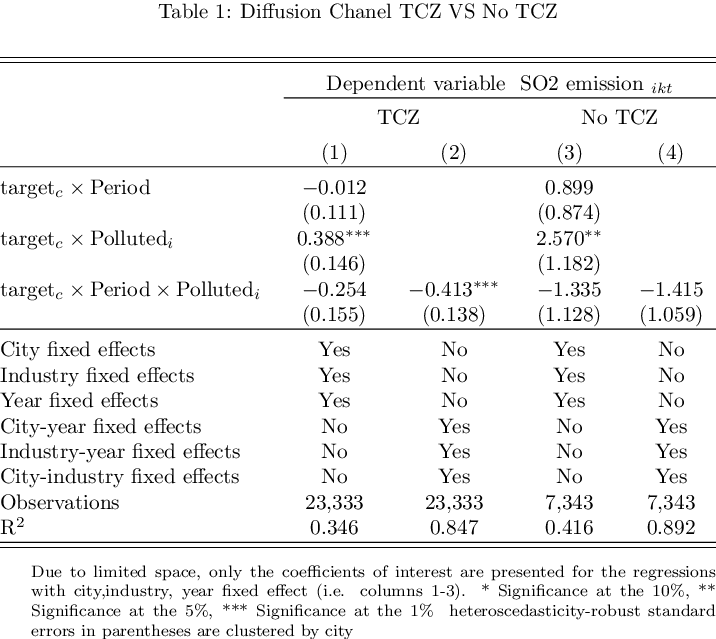

In [28]:
multicolumn ={
    'TCZ': 2,
    'No TCZ': 2,
}

new_r = ['& TCZ', 'TCZ', 'No TCZ', 'No TCZ']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""

#os.remove('table_1.tex')
x = [a for a in os.listdir() if a.endswith(".txt")]
for i, val in enumerate(x):
    lb.beautify(table_number = i+1,
            remove_control= True,
            constraint = True,
            city_industry = False, 
            new_row = False,
            multicolumn = multicolumn,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 150)

## Concentrated VS non concentrated

In [29]:
var_ <- 'decile_herfhindal'
df_to_filter <- df_herfhindal_r

toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

### concentration
t1 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > 
                                                     threshold_full),
             exactDOF=TRUE)
t1 <-change_target(t1)

t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > 
                                                     threshold_full),
             exactDOF=TRUE)
t2 <-change_target(t2)

### Non concentrated
t3 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= 
                                                     threshold_full),
             exactDOF=TRUE)
t3 <-change_target(t3)

t4 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= 
                                                     threshold_full),
             exactDOF=TRUE)
t4 <-change_target(t4)

name = paste0("table_",1,".txt")
    title = paste0("Diffusion Chanel Concentrated VS non concentrated")
    
tables <- list(t1, t2, t3, t4)
table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=title,
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name=name)

[1] TRUE TRUE TRUE

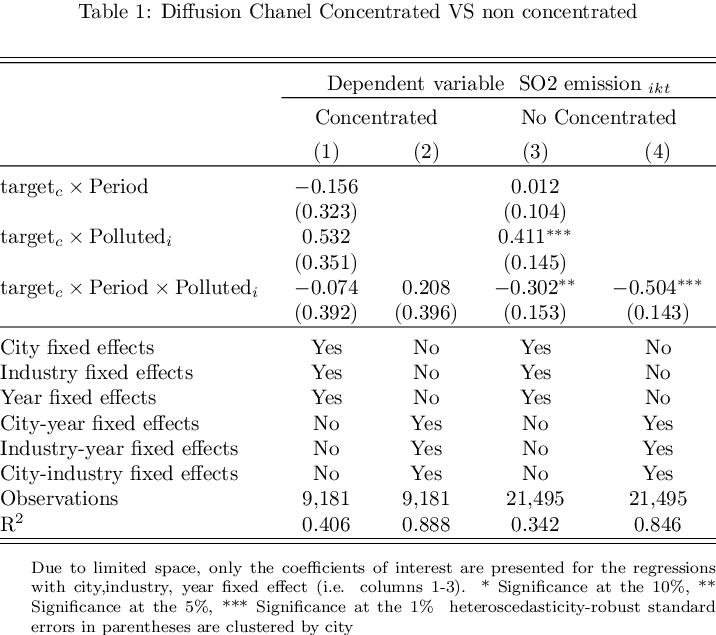

In [30]:
multicolumn ={
    'Concentrated': 2,
    'No Concentrated': 2,
}

new_r = ['& TCZ', 'TCZ', 'No TCZ', 'No TCZ']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""

#os.remove('table_1.tex')
x = [a for a in os.listdir() if a.endswith(".txt")]
for i, val in enumerate(x):
    lb.beautify(table_number = i+1,
            remove_control= True,
            constraint = True,
            city_industry = False, 
            new_row = False,
            multicolumn = multicolumn,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 150)

## Kuznet 

Estimate the following model

$$ Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }{i} \times \text { Polluting sectors }{k} \right)+Kuznet+\nu{i}+\lambda_{t}+\phi_{k}+\epsilon_{i k t} $$

$$ Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }{i} \times \text { Polluting sectors }{k} \right)+Kuznet+\nu_{ct}+\lambda_{kt}+\phi_{ck}+\epsilon_{i k t} $$


1. TCZ vs No TCZ
2. Concentrated vs No Concentrated
3. SOE vs No SOE
    - output
    - capital
    - employment

In [31]:
change_target <- function(table){
    check_target <- grep("PeriodAfter:polluted_threAbove:target_c$", rownames(table$coef))
    check_target_1 <- grep("PeriodAfter:target_c$", rownames(table$coef))
    check_target_2 <- grep("^polluted_threAbove:target_c$", rownames(table$coef))
    
    if (length(check_target) !=0) {
    # 1
    rownames(table$coefficients)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
    rownames(table$beta)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
        
    # 2
    rownames(table$coefficients)[check_target_1] <- 'target_c:PeriodAfter'
    rownames(table$beta)[check_target_1] <- 'target_c:PeriodAfter'
        
    # 3
    rownames(table$coefficients)[check_target_2] <- 'target_c:polluted_threAbove'
    rownames(table$beta)[check_target_2] <- 'target_c:polluted_threAbove'    
}
    return (table)
}

turning_point <- function(tables, currency ='RMB'){
    
    turning = c()
    turning_dol = c()
    for (c in tables){
        
        rmb <- round(exp(abs(coef(c)[grep("ln_gdp_cap$", names(coef(c)))] / 
                                   (2 * 
                                    coef(c)[grep("ln_gdp_cap_sqred$",
                                                  names(coef(c)))]))),0)
        
        dollars <- round(exp(abs(coef(c)[grep("ln_gdp_cap$", names(coef(c)))] / 
                                   (2 * 
                                    coef(c)[grep("ln_gdp_cap_sqred$",
                                                  names(coef(c)))])))/8.07,0)
        if (rmb > 100000 | rmb < 5000){
             rmb <- "-"
             dollars <- "-"
            
         }
        turning <- append(turning,rmb
                     )
        turning_dol <- append(turning_dol,dollars
                        )
    }
    if (currency == 'RMB'){
        return(turning)
        
    }else{
        return(turning_dol)
    }
}

In [32]:
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

#### TCZ
df_to_filter <- df_kuznet
t1 <- felm(formula=log(tso2_cit) ~ 
               + ln_gdp_cap
               + ln_gdp_cap_sqred
               + ln_pop
               + target_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c == 'TCZ'),
             exactDOF=TRUE)
t1 <-change_target(t1)

#### No TCZ
t2 <- felm(formula=log(tso2_cit) ~ 
               + ln_gdp_cap
               + ln_gdp_cap_sqred
               + ln_pop
               + target_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(TCZ_c != 'TCZ'),
             exactDOF=TRUE)
t2 <-change_target(t2)

### concentration
df_to_filter <- df_herfhindal_r
t3 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > 
                                                     threshold_full),
             exactDOF=TRUE)
t3 <-change_target(t3)

### Non concentrated
t4 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= 
                                                     threshold_full),
             exactDOF=TRUE)
t4 <-change_target(t4)

### SOE
df_to_filter <- df_final_SOE
### output
t5 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(output > threshold_full),
             exactDOF=TRUE)
t5 <-change_target(t5)
    
t6 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(output <= threshold_full),
             exactDOF=TRUE)
t6 <-change_target(t6)
    
### capital
t7 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(capital > threshold_full),
             exactDOF=TRUE)
t7 <-change_target(t7)
    
t8 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(capital <= threshold_full),
             exactDOF=TRUE)
t8 <-change_target(t8)
    
### employment
t9 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(employment > threshold_full),
             exactDOF=TRUE)
t9 <-change_target(t9)
    
t10 <- felm(formula=log(tso2_cit) ~ 
           + ln_gdp_cap
           + ln_gdp_cap_sqred
           + ln_pop
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             cityen +  year + industry  | 0 |
             industry, data= df_to_filter %>% filter(employment <= threshold_full),
             exactDOF=TRUE)
t10 <-change_target(t10)

name = paste0("table_",1,".txt")
    title = paste0("Diffusion Chanel Kuznet")
    
tables <- list(t1, t2, t3, t4, t5, t6, t7, t8, t9, t10)
turning <- turning_point(tables, currency = 'RMB')
turning_dol <- turning_point(tables, currency = 'dollars')
fe1 <- list(
    c('turning point RMB', turning),
    c('turning point Dollar', turning_dol),
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
      "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
      "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
      "Yes", "Yes", "Yes")
)

table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=title,
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name=name)

[1] TRUE TRUE TRUE

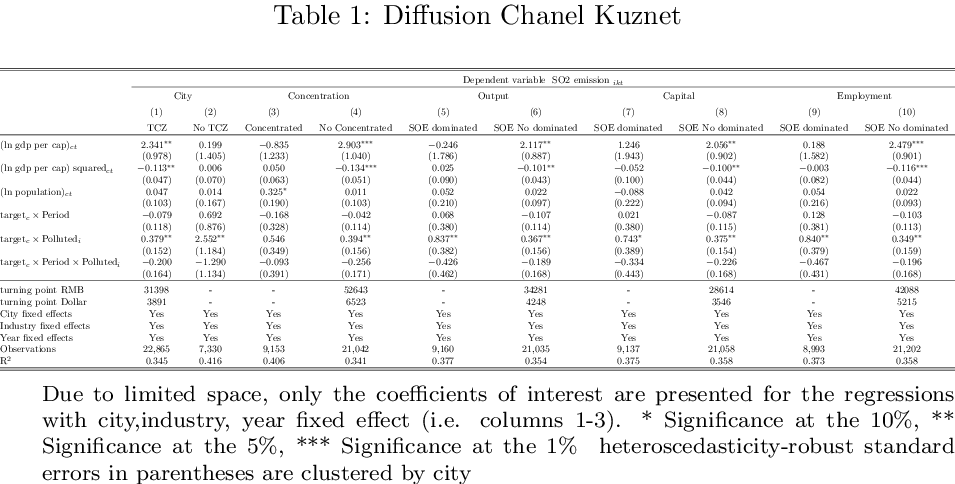

In [33]:
multicolumn ={
    'City': 2,
    'Concentration': 2,
    'Output': 2,
    'Capital': 2,
    'Employment': 2,
}

new_r = ['& TCZ', 'No TCZ', 'Concentrated', 'No Concentrated',
        'SOE dominated', 'SOE No dominated',
         'SOE dominated', 'SOE No dominated',
         'SOE dominated', 'SOE No dominated',
        ]

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""

#os.remove('table_1.tex')
x = [a for a in os.listdir() if a.endswith(".txt")]
for i, val in enumerate(x):
    lb.beautify(table_number = i+1,
            remove_control= True,
            constraint = True,
            city_industry = False, 
            new_row = new_r,
            multicolumn = multicolumn,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

# Create Report

In [39]:
import os, time, shutil
from pathlib import Path

filename = '10_SBC_final'
source = filename + '.ipynb'
source_to_move = filename +'.html'
path = os.getcwd()
parent_path = str(Path(path).parent)
path_report = "{}/Reports".format(parent_path)
dest = os.path.join(path_report, filename)+'_{}_{}_.html'.format(
    aggregation_param,
    threshold_full)

dest

'/Users/thomas/Google Drive/Projects/GitHub/Repositories/SBC_pollution_China/Data_analysis/Reports/10_SBC_final_geocode4_corr_6_.html'

In [ ]:
os.system('jupyter nbconvert --no-input --to html {}'.format(source))

time.sleep(5)
shutil.move(source_to_move, dest)
for i in range(1, 19):
    try:
        os.remove("table_{}.pdf".format(i))
        os.remove("table_{}.tex".format(i))
        os.remove("table_{}.txt".format(i))
    except:
        pass